# **House MD**
____________________________________________________________________
____________________________________________________________________
____________________________________________________________________

### Objective: To develop a Large Language Model (LLM)-assisted system that extracts structured clinical cases from TV show transcripts (House M.D.), identifying patient demographics, symptoms, relevant medical terms, and possible diagnoses.

ABSTRACT

This project explores the feasibility of detecting COVID-19 from chest X-ray images using convolutional neural networks. Using a curated dataset containing COVID-positive and non-COVID chest radiographs with metadata labels, we train a transfer learning model (ResNet50) to classify images and assess performance with standard classification metrics. Visual interpretability techniques (Grad-CAM) are applied to understand how the model localizes potential damage. This work highlights the potential — and limitations — of deep learning for radiological COVID-19 screening.

In [ ]:
!pip install kagglehub --quiet

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from glob import glob
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

#### Data Understanding

In [ ]:
import kagglehub

path = kagglehub.dataset_download("bachrr/covid-chest-xray")

print("Path to dataset files:", path)

100%|██████████| 241M/241M [00:08<00:00, 28.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/bachrr/covid-chest-xray/versions/4


In [ ]:
# look at columns

In [ ]:
metadata_path = "/kaggle/input/covid-chest-xray/metadata.csv"
df = pd.read_csv(metadata_path)
print("Columns in metadata.csv:")
print(df.columns.tolist())
df.head()

Columns in metadata.csv:
['patientid', 'offset', 'sex', 'age', 'finding', 'survival', 'intubated', 'intubation_present', 'went_icu', 'in_icu', 'needed_supplemental_O2', 'extubated', 'temperature', 'pO2_saturation', 'leukocyte_count', 'neutrophil_count', 'lymphocyte_count', 'view', 'modality', 'date', 'location', 'folder', 'filename', 'doi', 'url', 'license', 'clinical_notes', 'other_notes', 'Unnamed: 28']


,patientid,offset,sex,age,finding,survival,intubated,intubation_present,went_icu,in_icu,...,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 28
0,2,0.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,2,5.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
3,2,6.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
4,4,0.0,F,52.0,COVID-19,NaN,NaN,NaN,NaN,NaN,...,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


In [ ]:
# l00k at images

Total images: 57


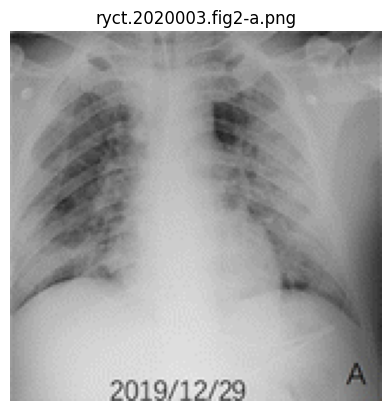

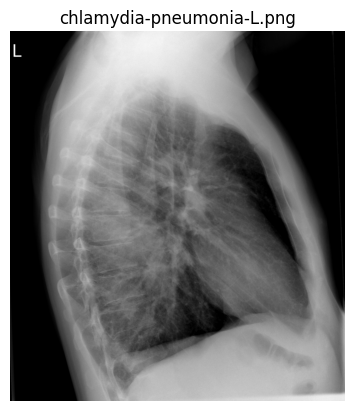

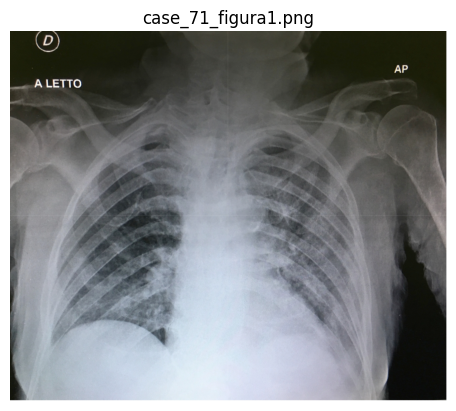

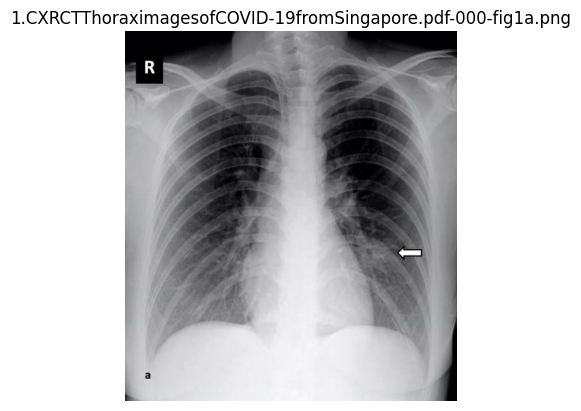

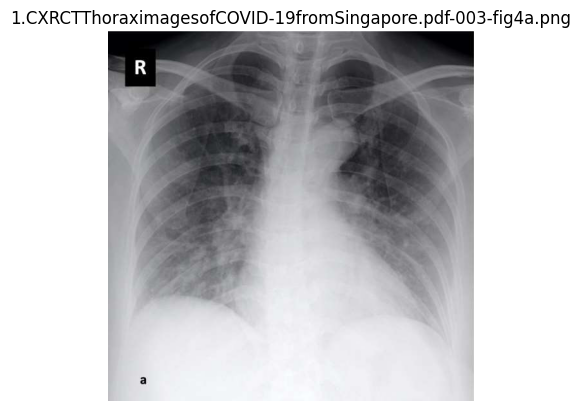

In [ ]:
image_files = glob(os.path.join(path, "**", "*.png"), recursive=True)
print(f"Total images: {len(image_files)}")

for img_path in image_files[:5]:
    img = Image.open(img_path)
    plt.imshow(img, cmap="gray")
    plt.title(os.path.basename(img_path))
    plt.axis("off")
    plt.show()

In [ ]:
# missing data

In [ ]:
missing_percent = df.isnull().mean() * 100
print("Missing data percentages per column:")
print(missing_percent.sort_values(ascending=False))
print(df.describe())


Missing data percentages per column:
neutrophil_count          99.462366
Unnamed: 28               98.924731
in_icu                    98.118280
lymphocyte_count          97.311828
leukocyte_count           97.043011
needed_supplemental_O2    96.774194
extubated                 93.817204
went_icu                  90.591398
temperature               90.591398
pO2_saturation            88.172043
intubated                 80.645161
intubation_present        79.301075
doi                       72.043011
survival                  68.817204
license                   44.623656
other_notes               37.096774
location                  31.720430
offset                    25.806452
date                      21.774194
age                       14.516129
sex                       11.559140
clinical_notes             2.688172
finding                    0.000000
patientid                  0.000000
modality                   0.000000
view                       0.000000
url                        

What the missing data percentages tell us:
Very high missing rates (>80%) for clinical/lab measures like:

neutrophil_count (99% missing)

lymphocyte_count (97% missing)

leukocyte_count (97% missing)

intubated, in_icu, went_icu, temperature, pO2_saturation, etc.

Implication: These variables are almost entirely missing and are unlikely to be useful for modeling unless you do heavy imputation or remove missing rows (which might reduce dataset size drastically).

Moderate missingness (~20-30%) for:

offset (days since symptoms/imaging)

date, location

Implication: You can keep these but may need to handle missing values carefully.

Low missingness (<15%) for:

age (14%)

sex (11%)

clinical_notes (2.7%)

These are valuable demographic and text fields with relatively complete data.

📊 Summary stats notes:
Age: Mean ~56 years, range 12–88, reasonable for adult COVID patients.

Temperature: Mean ~39.8°C, quite high—fever is common.

pO2_saturation: Mean ~88%, shows some degree of hypoxia in many patients.

Lab counts (leukocyte, neutrophil, lymphocyte) have very few valid records—likely unusable for now.

🔥 Recommended next steps for data cleaning & modeling:
Drop columns with >80% missing values unless you want to do special imputation (likely better to drop for now):

Copy
Edit
neutrophil_count, lymphocyte_count, leukocyte_count, in_icu, intubated, needed_supplemental_O2, extubated, went_icu, temperature, pO2_saturation, intubation_present
Keep columns with relatively complete data, including:

pgsql
Copy
Edit
patientid, offset, sex, age, finding, survival, view, modality, date, location, filename, clinical_notes
Handle missing age and sex by:

Either drop rows missing those

Or impute (median for age, most common for sex) if you want to preserve data.

For modeling COVID detection, your core features are:

The images themselves

Labels from finding (COVID vs non-COVID)

Optional metadata like age and sex as additional inputs or for stratification

For severity or survival prediction, you can:

Use survival (Y/N) with caution (missing 68%)

Extract severity labels from clinical_notes (more work but feasible)

In [ ]:
# clean data

In [ ]:
cols_to_drop = [
    'neutrophil_count', 'lymphocyte_count', 'leukocyte_count', 'in_icu',
    'intubated', 'needed_supplemental_O2', 'extubated', 'went_icu',
    'temperature', 'pO2_saturation', 'intubation_present', 'Unnamed: 28'
]

df_clean = df.drop(columns=cols_to_drop)

df_clean = df_clean.dropna(subset=['finding', 'filename'])

print(f"Cleaned data shape: {df_clean.shape}")
print(df_clean.isnull().mean() * 100)

Cleaned data shape: (372, 17)
patientid          0.000000
offset            25.806452
sex               11.559140
age               14.516129
finding            0.000000
survival          68.817204
view               0.000000
modality           0.000000
date              21.774194
location          31.720430
folder             0.000000
filename           0.000000
doi               72.043011
url                0.000000
license           44.623656
clinical_notes     2.688172
other_notes       37.096774
dtype: float64


#### Data PreProcessing

In [ ]:
dataset_path = path
images_folder = os.path.join(dataset_path, "images")

In [ ]:
def load_and_preprocess_image(img_path, img_size=IMG_SIZE):
    img = Image.open(img_path).convert("RGB")
    img = img.resize((img_size, img_size))
    img_array = np.array(img) / 255.0
    return img_array


In [ ]:
image_filenames = os.listdir(images_folder)

image_paths = [os.path.join(images_folder, f) for f in image_filenames]

images = np.array([load_and_preprocess_image(p) for p in image_paths])

print(f"Loaded {len(images)} images with shape {images[0].shape}")

Loaded 357 images with shape (224, 224, 3)


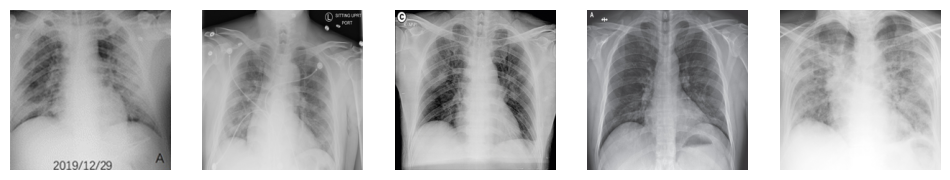

In [ ]:
plt.figure(figsize=(12, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

#### Prepare for training

In [ ]:
metadata_path = os.path.join(dataset_path, "metadata.csv")
df_meta = pd.read_csv(metadata_path)

df_meta['is_covid'] = df_meta['finding'].str.lower().apply(lambda x: 1 if 'covid' in x else 0)

print(f"Metadata shape: {df_meta.shape}")
print(df_meta['is_covid'].value_counts())

Metadata shape: (372, 30)
is_covid
1    308
0     64
Name: count, dtype: int64


In [ ]:
filename_to_label = dict(zip(df_meta['filename'], df_meta['is_covid']))

In [ ]:
labels = []

for fname in image_filenames:
    label = filename_to_label.get(fname)
    if label is not None:
        labels.append(label)
    else:
        labels.append(-1)

print(f"Total labels assigned: {len(labels)}")
print(f"Labels distribution: {pd.Series(labels).value_counts()}")

Total labels assigned: 357
Labels distribution:  1    287
 0     64
-1      6
Name: count, dtype: int64


In [ ]:
valid_indices = [i for i, lbl in enumerate(labels) if lbl != -1]

images_filtered = images[valid_indices]
labels_filtered = np.array([labels[i] for i in valid_indices])

print(f"Filtered images shape: {images_filtered.shape}")
print(f"Filtered labels distribution:\n{pd.Series(labels_filtered).value_counts()}")


Filtered images shape: (351, 224, 224, 3)
Filtered labels distribution:
1    287
0     64
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

X_trainval, X_test, y_trainval, y_test = train_test_split(
    images_filtered, labels_filtered, test_size=0.1, stratify=labels_filtered, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.1111, stratify=y_trainval, random_state=42
)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")
print(f"Train labels distribution:\n{pd.Series(y_train).value_counts()}")
print(f"Validation labels distribution:\n{pd.Series(y_val).value_counts()}")
print(f"Test labels distribution:\n{pd.Series(y_test).value_counts()}")


Train shape: (280, 224, 224, 3), Validation shape: (35, 224, 224, 3), Test shape: (36, 224, 224, 3)
Train labels distribution:
1    229
0     51
Name: count, dtype: int64
Validation labels distribution:
1    29
0     6
Name: count, dtype: int64
Test labels distribution:
1    29
0     7
Name: count, dtype: int64


In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

val_datagen = ImageDataGenerator()

In [ ]:
batch_size = 32

train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=batch_size,
    shuffle=True
)

val_generator = val_datagen.flow(
    X_val, y_val,
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
test_generator = val_datagen.flow(
    X_test, y_test,
    batch_size=batch_size,
    shuffle=False
)

## CNN model

In [ ]:
model = models.Sequential([
    layers.Input(shape=(224,224,3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_val, y_val)
)


Epoch 1/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.6075 - loss: 1.0639 - val_accuracy: 0.8286 - val_loss: 0.4481
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.8308 - loss: 0.5071 - val_accuracy: 0.8286 - val_loss: 0.4474
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.8098 - loss: 0.5000 - val_accuracy: 0.8286 - val_loss: 0.4267
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.8010 - loss: 0.4847 - val_accuracy: 0.8286 - val_loss: 0.4131
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.8155 - loss: 0.4477 - val_accuracy: 0.8286 - val_loss: 0.3944
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.8309 - loss: 0.3922 - val_accuracy: 0.8286 - val_loss: 0.4013
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.8311 - loss: 0.3686 - val_accuracy: 0.8000 - val_loss: 0.3845
Epoch 8/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.8505 - loss: 0.3734 - val_accuracy: 0.8286 - val_loss: 0.3911
Epoch 9/

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 289ms/step - accuracy: 0.7500 - loss: 0.6605
Test accuracy: 0.7500


Here’s a quick summary of what happened:

Your simple CNN trained well and improved training accuracy to over 94% by epoch 15.

Validation accuracy hovered around 77–88%, showing some generalization but maybe slight overfitting.

Test accuracy came out at 75%, which is solid for a small dataset and simple model.


In [ ]:
import os

# Replace this with the actual path from your kagglehub.dataset_download() call
dataset_path = "/content/kagglehub-datasets/bachrr/covid-chest-xray"

# Supported image extensions
image_extensions = ['.png', '.jpg', '.jpeg']

# Walk through directory and count image files
image_count = 0
image_paths = []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if any(file.lower().endswith(ext) for ext in image_extensions):
            image_count += 1
            image_paths.append(os.path.join(root, file))

print(f"Total number of image files: {image_count}")


Total number of image files: 0
